# Parse TI's Mm-Wave Radar ADC Data Captured by DCA1000

In [1]:
import numpy as np
from struct import *
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sns.set_style('darkgrid')

In [2]:
def parse_a2d(file_name):
    numADCSamples = 256  # number of ADC samples per chirp
    numADCBits = 16  # number of ADC bits per sample
    numRX = 4  # number of receivers
    numLanes = 2  # do not change. number of lanes is always 2
    isReal = 0  # set to 1 if real only data, 0 if complex data0

    chirps_per_frame = 32
    num_frames = 256

    if isReal == 0:
        data_length = numADCSamples * chirps_per_frame * num_frames * numRX * 2
    else:
        data_length = numADCSamples * chirps_per_frame * num_frames * numRX

    fp = open(file_name, 'rb')
    x = fp.read()
    fp.close()
    data = np.array(unpack('<' + str(data_length) + 'h', x))

    # if 12 or 14 bits ADC per sample compensate for sign extension
    if numADCBits != 16:
        l_max = 2**(numADCBits - 1) - 1
        data[np.where(
            data > l_max)] = data[np.where(data > l_max)] - 2**numADCBits

    if isReal:
        numChirps = int(data_length / numADCSamples / numRX)
        LVDS = np.zeros((1, data_length), dtype=complex)
        # create column for each chirp
        LVDS = np.transpose(
            np.reshape(data, (numADCSamples * numRX, numChirps), order="F"))
    else:
        numChirps = int(data_length / 2 / numADCSamples / numRX)

        LVDS = np.zeros((1, int(data_length / 2)), dtype=complex)

        counter = 0
        for i in range(0, data_length, 4):
            LVDS[0, counter] = data[i] + 1j * data[i + 2]
            LVDS[0, counter + 1] = data[i + 1] + 1j * data[i + 3]
            counter = counter + 2

        LVDS = np.transpose(
            np.reshape(LVDS, (numADCSamples * numRX, numChirps), order="F"))

    a2d_data = np.zeros((numRX, num_frames, chirps_per_frame, numADCSamples),
                        dtype=complex)

    for frame_idx in range(0, num_frames):
        for chirp_idx in range(0, chirps_per_frame):
            for rx_idx in range(0, numRX):
                idx = frame_idx * chirps_per_frame + chirp_idx
                a2d_data[rx_idx, frame_idx, chirp_idx, :] = LVDS[
                    idx, rx_idx * numADCSamples:(rx_idx + 1) * numADCSamples]

    return a2d_data

In [3]:
# [rx_channel, frame, chirp, sample]
a2d_data = parse_a2d('data/adc_data.bin')

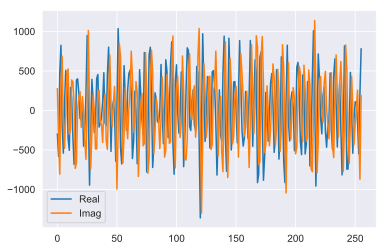

In [4]:
plt.plot(np.real(a2d_data[1, 110, 19, :]), label='Real')
plt.plot(np.imag(a2d_data[1, 110, 19, :]), label='Imag')
plt.legend()